# SVR

Bu çalışmada veri seti üzerinde destek vektör regresyonu deneyeceğiz. Destek vektör ilk olarak sınıflandırma problemleri için çıkmış daha sonra regresyon problemlerine de uyarlanmış bir algoritmadır. Amacı, bir marjin aralığında maximum noktayı en az hata ile alacak doğru veya eğri çizmektir. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
from sklearn import model_selection
from warnings import filterwarnings
from sklearn.svm import SVR
filterwarnings("ignore")

In [2]:
#Veri ön işleme aşamalarını yapalım.
#Öncelikle basit svr denemek için bağımsız değişkenlerden sadece hits değişkenini seçiyoruz.
#Böylece veri seti bir girdi ve bir çıktı şeklinde oluyor.
data=pd.read_csv("Hitters.csv")
df=data.copy()
df=df.dropna()
dms=pd.get_dummies(df[["League","Division","NewLeague"]])
y=df["Salary"]
x=df.drop(["Salary","League","Division","NewLeague"],axis=1).astype("float64")
x=pd.concat([x,dms[["League_N","Division_W","NewLeague_N"]]],axis=1)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42)
x_train=pd.DataFrame(x_train["Hits"])
x_test=pd.DataFrame(x_test["Hits"])

In [3]:
#Modelimizi kuralım.
#SVR'ın bir de doğrusal olmayan hali olduğu için doğrusal olduğunu belirtmemiz gerekiyor.
#SVR'ın formülünde lasso ve ridge'de olduğu gibi bir ceza parametresi vardır.
#C parametresi ceza katsayısını ayarlar, ön tanımlı olarak 1 girilmiştir.
svr=SVR("linear").fit(x_train,y_train)

In [4]:
"Modelin kurduğu denklem: y = {0} + {1} * Hits ".format(svr.intercept_[0],svr.coef_[0][0])

'Modelin kurduğu denklem: y = -48.69756097561513 + 4.969512195122093 * Hits '

In [5]:
y_pred=svr.predict(x_test)

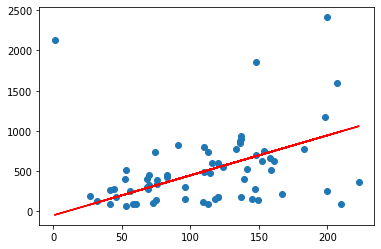

In [6]:
#SVR'ın oluşturduğu doğruyu grafikte görelim.
plt.scatter(x_test,y_test)
plt.plot(x_test,y_pred,color="r");

In [7]:
#Veri setini bir de doğrusal regresyon kullanarak modelleyelim ve farkını görelim.
from sklearn.linear_model import LinearRegression
model=LinearRegression().fit(x_train,y_train)
y_pred_lm=model.predict(x_test)

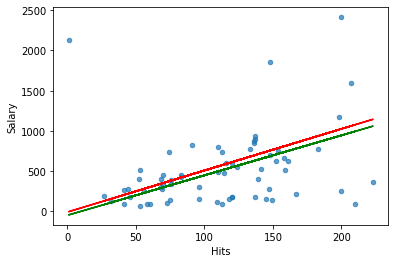

In [8]:
#SVR ve doğrusal regresyon modellerini grafiğe çizdirdiğimiz zaman doğrusal modelin daha yukarda olduğunu görüyoruz.
#Bunun nedeni veri setinden çok yukarda kalmış olan aykırı değerlerin doğrusal modele daha çok etki etmesidir.
#SVR model aykırı değerlere daha dayanıklıdır ve daha doğru sonuçlar verir.
plt.scatter(x_test,y_test,alpha=0.7,s=20)
plt.plot(x_test,y_pred,color="g")
plt.plot(x_test,y_pred_lm,color="r")
plt.xlabel("Hits")
plt.ylabel("Salary");

In [9]:
#İki modelin test hatalarına baktığımızda da SVR'ın daha az hata verdiğini görüyoruz.
"SVR'ın test hatası",np.sqrt(mean_squared_error(y_test,y_pred))

("SVR'ın test hatası", 459.0187960365147)

In [10]:
"Doğrusal modelin test hatası",np.sqrt(mean_squared_error(y_test,y_pred_lm))

('Doğrusal modelin test hatası', 464.4153652214483)

In [11]:
#SVR'ı tune etme işlemlerine geçelim.
#SVR'ın hiper parametresi C katsaysıdır. 
#C'yi optimize etmek için belirli bir aralıkta parametre seti oluşturup GridSearchCV fonksiyonuyla optimumunu bulacağız.
svr_params={"C":np.arange(0.1,2,0.1)}
svr_cv=GridSearchCV(svr,svr_params,cv=10).fit(x_train,y_train)

In [12]:
#Optimum c değeri.
svr_cv.best_params_

{'C': 0.1}

In [13]:
#Optimum c değeri ile final modelini kuralım.
svr_tuned=SVR("linear",C=pd.Series(svr_cv.best_params_)[0]).fit(x_train,y_train)

In [14]:
y_pred_tuned=svr_tuned.predict(x_test)

In [15]:
#Optimum c ile kurulan modelin hatasının daha düşük olduğunu görüyoruz.
"Tune edilmiş modelin test hatası: ",np.sqrt(mean_squared_error(y_test,y_pred_tuned))

('Tune edilmiş modelin test hatası: ', 458.198966781116)

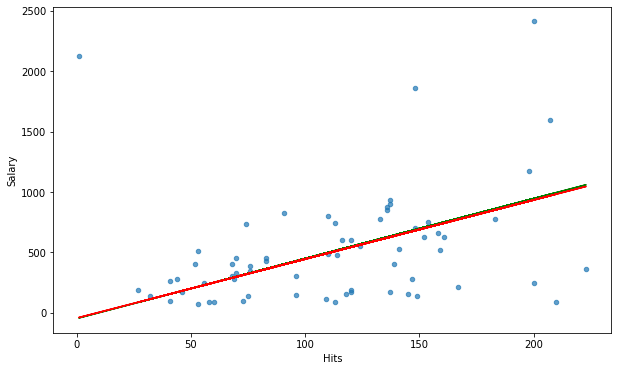

In [16]:
plt.figure(figsize=(10,6))
plt.scatter(x_test,y_test,alpha=0.7,s=20)
plt.plot(x_test,y_pred,color="g")
plt.plot(x_test,y_pred_tuned,color="r")
plt.xlabel("Hits")
plt.ylabel("Salary");
#Tune edilmiş modelin çok az bir fark ile daha aşşağıda olduunu görüyoruz.

In [17]:
#Modeli bir de bütün değişkenleri kullanarak kurmayı deneyelim.
x_train2,x_test2,y_train2,y_test2=train_test_split(x,y,test_size=0.25,random_state=42)

In [18]:
#Bütün değişkenler ile optimum c ararken işlem çok uzun süreceğinden aralığı biraz daraltalım.
svr_params={"C":np.arange(0.2,1,0.2)}
svr_cv2=GridSearchCV(svr,svr_params,cv=10).fit(x_train2,y_train2)

In [19]:
svr_cv2.best_params_

{'C': 0.4}

In [20]:
#Bütün değişkenleri kullanarak bulduğumuz optimum c ile final modelini kuralım.
svr_tuned2=SVR("linear",C=pd.Series(svr_cv2.best_params_)[0]).fit(x_train2,y_train2)
y_pred_tuned2=svr_tuned2.predict(x_test2)

In [21]:
#Bütün değişkenleri kullanarak kurulan modelin hatasının daha az olduğunu görüyoruz.
#Veri setini açıklamada diğer parametrelerin de etkisi varmış.
np.sqrt(mean_squared_error(y_test2,y_pred_tuned2))

367.5385297249052